<a href="https://colab.research.google.com/github/manaswitac/Detecting-Depression-Through-Tweets/blob/main/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
#Importing csv into a Dataframe
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Data/Sentiment Analysis Dataset 2.csv',on_bad_lines = 'skip')
data = df[['Sentiment','SentimentText']]

In [ ]:
import string
import nltk
nltk.download()
nltk.download('stopwords') 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from textblob import Word

stopwords = nltk.corpus.stopwords.words('english')

def cleaning(text):
  returntext = ""  
  for i in text:
    if i not in string.punctuation:
      returntext = returntext + i
  returntext = returntext.lower() 
  returntext = ' '.join(i for i in returntext.split() if i not in stopwords) 
  returntext = ' '.join([Word(i).lemmatize() for i in returntext.split()])   
  return returntext

data['CleanedText'] = data.loc[:,'SentimentText'].apply(lambda x: cleaning(x))
print(data.head())

   Sentiment                                      SentimentText  \
0          0                       is so sad for my APL frie...   
1          0                     I missed the New Moon trail...   
2          1                            omg its already 7:30 :O   
3          0            .. Omgaga. Im sooo  im gunna CRy. I'...   
4          0           i think mi bf is cheating on me!!!   ...   

                                         CleanedText  
0                                     sad apl friend  
1                            missed new moon trailer  
2                                    omg already 730  
3  omgaga im sooo im gunna cry ive dentist since ...  
4                            think mi bf cheating tt  


<ipython-input-22-e8cc84603fd1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CleanedText'] = data.loc[:,'SentimentText'].apply(lambda x: cleaning(x))


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(data['CleanedText'].values)
X = tokenizer.texts_to_sequences(data['CleanedText'].values)
X = pad_sequences(X)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embed_dim = 50
lstm_out = 80
model = Sequential()
model.add(Embedding(2000,50,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(80, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 46, 50)            100000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 46, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 80)                41920     
                                                                 
 dense_1 (Dense)             (None, 2)                 162       
                                                                 
Total params: 142,082
Trainable params: 142,082
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Y = pd.get_dummies(data['Sentiment']).values
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
X_test = X[round(len(X)*0.8):]
Y_test = Y[round(len(X)*0.8):]
X_val = X[round(len(X)*0.6):round(len(X)*0.8)]
Y_val = Y[round(len(Y)*0.6):round(len(X)*0.8)]
X_train = X[:round(len(X)*0.6)]
Y_train = Y[:round(len(Y)*0.6)]
early_stop = EarlyStopping(monitor='val_loss', patience=3)
hist = model.fit(X_train, Y_train,validation_data=(X_val,Y_val), epochs=5, batch_size=32, shuffle=True, callbacks=[early_stop])
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

Epoch 1/5
1875/1875 [==============================] - 158s 82ms/step - loss: 0.5471 - accuracy: 0.7175 - val_loss: 0.5185 - val_accuracy: 0.7393
Epoch 2/5
1875/1875 [==============================] - 139s 74ms/step - loss: 0.5080 - accuracy: 0.7472 - val_loss: 0.5116 - val_accuracy: 0.7454
Epoch 3/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.4980 - accuracy: 0.7535 - val_loss: 0.5100 - val_accuracy: 0.7440
Epoch 4/5
1875/1875 [==============================] - 139s 74ms/step - loss: 0.4892 - accuracy: 0.7593 - val_loss: 0.5104 - val_accuracy: 0.7444
Epoch 5/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.4825 - accuracy: 0.7631 - val_loss: 0.5194 - val_accuracy: 0.7451
625/625 - 6s - loss: 0.5212 - accuracy: 0.7462 - 6s/epoch - 10ms/step
score: 0.52
acc: 0.75


In [ ]:
import pickle
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(model,picklefile)

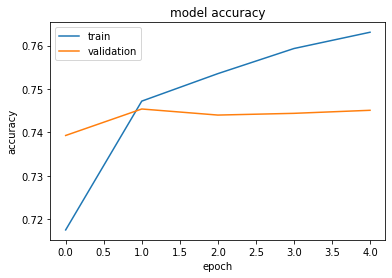

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

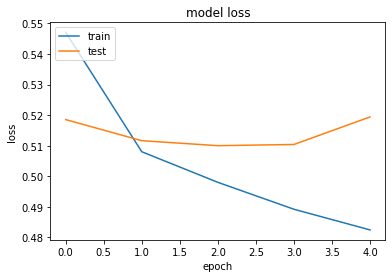

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import gensim
Words = [word.split() for word in data['CleanedText']]
W2V_model = gensim.models.word2vec.Word2Vec(size=300,window=7,min_count=1,workers=8,sg = 1)
W2V_model.build_vocab(Words)

In [ ]:
W2V_model.train(Words, total_examples=len(Words), epochs=32)

(23965876, 25352480)

In [ ]:
import numpy as np
class LogReg:

    def __init__(self, l_rate, epochs, n_features):
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        if abs(score.any()) > threshold:
            score = threshold * np.sign(score)
        activation = np.exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [ ]:
def get_accuracy(y_bar, y_pred):
    correct = 0
    for i in range(len(y_bar)):
        if np.array_equal(y_bar[i],y_pred[i]):
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

In [ ]:
logreg = LogReg(0.1,5, len(X_train[0]))
bias_logreg, weights_logreg = logreg.train(X_train, Y_train)
y_logistic = [np.round(logreg.predict(example)) for example in X_test]

<ipython-input-31-37b14bab1aba>:13: RuntimeWarning: overflow encountered in exp
  activation = np.exp(score)
<ipython-input-31-37b14bab1aba>:14: RuntimeWarning: invalid value encountered in true_divide
  return activation / (1.0 + activation)


In [ ]:
# Compare accuracies
accuracy_logistic = get_accuracy(y_logistic, Y_test)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 0.000
